# ML Bootcamp: Denmark Weather RNN

In this lab, we will implement RNN models using Keras. We will use weather data from cities in Denmark.

## Data Loading

We first have to download the data to our local Google Colab VM. After running the following code, you should see a file "weather-denmark.csv" when you click on the folder icon on the left side of the screen.

**Side Note:** Prepending an exclamation point before lines in Colab allows you to run normal Unix commands (if you're familiar with Linux or the Terminal app on MacOS, both are Unix-based). The *wget* and *tar* commands fetch a file from a URL and unpackage a tar archive, respectively.

In [ ]:
!wget https://github.com/Hvass-Labs/weather-denmark/raw/master/weather-denmark.tar.gz
!tar -xvzf weather-denmark.tar.gz

--2020-05-31 18:58:20--  https://github.com/Hvass-Labs/weather-denmark/raw/master/weather-denmark.tar.gz
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Hvass-Labs/weather-denmark/master/weather-denmark.tar.gz [following]
--2020-05-31 18:58:20--  https://raw.githubusercontent.com/Hvass-Labs/weather-denmark/master/weather-denmark.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35332031 (34M) [application/octet-stream]
Saving to: ‘weather-denmark.tar.gz’

weather-denmark.tar 100%[===================>]  33.69M  83.9MB/s    in 0.4s    

2020-05-31 18:58:22 (83.9 MB/s) - ‘weather-denmark.tar.gz’ sa

Next, we read the data from the comma-separated file (CSV) into a Pandas dataframe. This data contains time-series information about the temperature, wind speed, wind direction, and pressure on 5 cities in Denmark. We use the `set_index` method to group the data first by city, and second by the time.

In [ ]:
import pandas as pd
df = pd.read_csv('weather-denmark.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index(['City', 'DateTime'], inplace=True)
df.head()

Temp  Pressure  WindSpeed  WindDir
City    DateTime                                               
Aalborg 1980-03-01 00:00:00   5.0    1008.1       11.3    290.0
        1980-03-01 00:20:00   4.0       NaN        9.2    270.0
        1980-03-01 00:50:00   4.0       NaN        9.2    280.0
        1980-03-01 01:20:00   4.0       NaN        9.2    280.0
        1980-03-01 01:50:00   4.0       NaN        8.7    270.0

Next, we clean the data up by resampling each city to be hourly. To do this, we linearly interpolate the data up to the minute, and then keep one data point every 60 minutes. This step may take a minute to run.

In [ ]:
def resample_to_hourly(df):
  """
  Resample the data into hours. Note that interpolation after resampling is
  necessary and converts back into a Pandas dataframe.
  """
  df_res = df.dropna(how='all').resample('1T').interpolate(method='time')
  return df_res.resample('60T').interpolate()

# Resample for each city independently.
cities = ['Aalborg', 'Odense', 'Roskilde', 'Aarhus', 'Esbjerg'] # You could modify this to process data for other cities
df_cities = [resample_to_hourly(df.xs(city)) for city in cities]

# Re-join data into a single dataframe.
df = pd.concat(df_cities, keys=cities, axis=1, join='inner')

df.head()

Aalborg               ...    Esbjerg            
                         Temp     Pressure  ...  WindSpeed     WindDir
DateTime                                    ...                       
1980-03-01 10:00:00  4.333333  1007.533333  ...        NaN         NaN
1980-03-01 11:00:00  5.000000  1007.766667  ...  12.383333  310.000000
1980-03-01 12:00:00  5.000000  1008.000000  ...  12.883333  310.000000
1980-03-01 13:00:00  5.000000  1008.066667  ...  13.244444  309.444444
1980-03-01 14:00:00  4.333333  1008.133333  ...  12.911111  306.111111

[5 rows x 20 columns]

While this dataset includes information for five different cities in Denmark, we will just be working with a single city: Odense. We finish up our data loading by plotting some of the data to get a grip on what the values look like.

**Side Note:** You might notice the spikes on the temperature plot below (up to 50 degrees Celsius!). No dataset is perfect, and this one is no exception. Those spikes are just errors. When working on your projects you should make sure that you look at the data to understand the limits of the dataset. You don't want to fit noise!

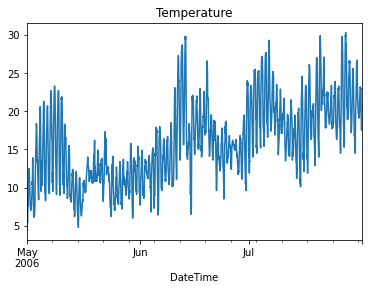

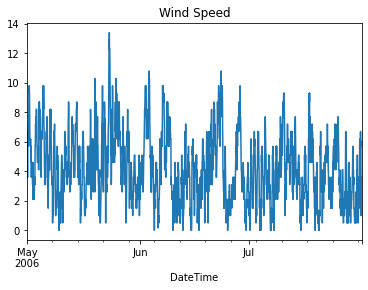

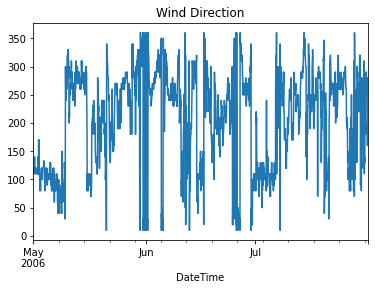

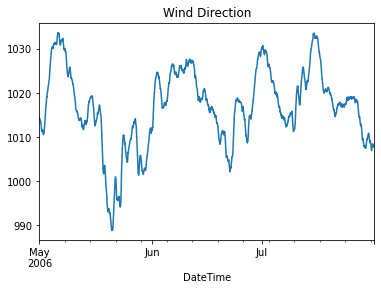

In [ ]:
import matplotlib.pyplot as plt
df = df["Aalborg"] # Run this only once!
df["Temp"]['2006-05':'2006-07'].plot(title="Temperature")
plt.show()
df["WindSpeed"]['2006-05':'2006-07'].plot(title="Wind Speed")
plt.show()
df["WindDir"]['2006-05':'2006-07'].plot(title="Wind Direction")
plt.show()
df["Pressure"]['2006-05':'2006-07'].plot(title="Wind Direction")
plt.show()

## Data Pre-Processing

Next, we get the data ready for input into our RNN! We are going to try and predict the temperature 24 hours in the future. To do this, we need to great an array of targets (i.e., our true labels). Since the true label for a sequence that ends at time **i** is the temperature at time **i + 24**, we need to shift the data backwards to get our labels.

In [ ]:
target_hours = 12

# Create targets for RNN (Exercise: why do we multiply by -1?)
labels = df[['Pressure']].shift(-1 * target_hours)
labels.head()

,Pressure
DateTime,
1980-03-01 10:00:00,1010.533333
1980-03-01 11:00:00,1010.066667
1980-03-01 12:00:00,1009.600000
1980-03-01 13:00:00,1008.800000
1980-03-01 14:00:00,1008.000000


Next, we convert our labels and data into Numpy arrays. When doing this, we have to be careful to remove the last data points (as we have no labels for those data points!).

In [ ]:
X = df.values[0:-1 * target_hours]
y = labels.values[0:-1 * target_hours]
print(X.shape, y.shape)

(333098, 4) (333098, 1)


We reserve 10% of data for testing. When doing this, we cannot use our usual methods for splitting the data (e.g., using Scikit-Learn's *train_test_split*) because shuffling the data would destroy the time-dependent nature.

In [ ]:
import math
num_examples = X.shape[0]
test_proportion = 0.1
num_test_examples = math.ceil(test_proportion * num_examples)
X_train = X[0:-1 * num_test_examples, :]
y_train = y[0:-1 * num_test_examples, :]
X_test = X[-1 * num_test_examples:, :]
y_test = y[-1 * num_test_examples:, :]

It's often a good idea to rescale your data (data normalized between 0 and 1 is particularly nice for neural networks -- if you want to learn more about this, take the *Machine Learning in the Real World* camp!). We do this with a nice Scikit-Learn object `MinMaxScaler` that uses a linear transform to put our data in the range 0 to 1. This object remembers the transform so we can undo it later during post-processing.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Rescale the X and y values. Note that these must be rescaled separately
# because the dimensions are different.
rescaler = MinMaxScaler()
X_train_rescaled = rescaler.fit_transform(X_train)
X_test_rescaled = rescaler.transform(X_test)
y_rescaler = MinMaxScaler()
y_train_rescaled = y_rescaler.fit_transform(y_train)
y_test_rescaled = y_rescaler.transform(y_test)

# Check rescaling
print(np.min(X_train_rescaled), np.max(X_train_rescaled))
print(np.min(y_train_rescaled), np.max(y_train_rescaled))

0.0 1.0000000000000002
0.0 1.0


# A (Bad) RNN Model

The input to the Keras `SimpleRNN` is a 3D array where each row is a sequence of observations (and for us, each observation consists of the wind direction, wind speed, pressure, and temperature). Currently, our data is only 2D because we just have one long sequence!

In order to get our data ready for Keras, we will naively just take each contiguous sequence of *L* data points and add that as a row to an array (where *L* is some constant). It would be better if we selected these sequences randomly either by shuffling the data (which you will do as an exercise) or using a Python generator.

In [ ]:
def batch_for_keras(X_data, y_data, seq_length):
  num_examples = X_data.shape[0] - seq_length
  X_res = np.zeros((num_examples, seq_length, X_data.shape[1]))
  y_res = np.zeros((num_examples, seq_length, y_data.shape[1]))
  for i in range(num_examples):
    X_res[i, :, :] = X_data[i : i + seq_length, :]
    y_res[i, :, :] = y_data[i : i + seq_length, :]
  return (X_res, y_res)

seq_length = 24 * 7 # Each sequence will be one week long
X_train_keras, y_train_keras = batch_for_keras(X_train_rescaled, y_train_rescaled, seq_length)
X_test_keras, y_test_keras = batch_for_keras(X_test_rescaled, y_test_rescaled, seq_length)
print(X_train_keras.shape)

(299620, 168, 4)


We next define our model! Our first RNN will be a single RNN unit, followed by  a dense unit that outputs a single number. Finally, we apply sigmoid to this number (exercise: why do we use sigmoid here?). You can play around with the RNN activation function and the number of units.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

num_signals = X_train_rescaled.shape[1]   # 4 in our case
num_y_signals = y_train_rescaled.shape[1] # 1 in our case

model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(None, num_signals), return_sequences=True, activation='sigmoid'))
model.add(Dense(num_y_signals, activation='sigmoid')) # why do we use sigmoid?
model.compile(loss="mean_squared_error", optimizer="rmsprop")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 32)          1184      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


Finally, we train the model. We will only train for 5 epochs and run 100 batches each epoch.

In [ ]:
model.fit(X_train_keras, y_train_keras, epochs=5, steps_per_epoch=100, batch_size=32)

Epoch 1/5
100/100 [==============================] - 3s 30ms/step - loss: 0.0156
Epoch 2/5
100/100 [==============================] - 3s 28ms/step - loss: 0.0138
Epoch 3/5
100/100 [==============================] - 3s 29ms/step - loss: 0.0128
Epoch 4/5
100/100 [==============================] - 3s 28ms/step - loss: 0.0111
Epoch 5/5
100/100 [==============================] - 3s 29ms/step - loss: 0.0097


We can evaluate the model on your test set to see how well it generalizes.

In [ ]:
result = model.evaluate(x=np.expand_dims(X_test_rescaled, axis=0),
                        y=np.expand_dims(y_test_rescaled, axis=0))

1/1 [==============================] - 0s 1ms/step - loss: 0.0075


# Evaluation

Now that we have our model, our next step is to evaluate the predictions! Aside from investigating the error via different metrics, we can plot the data to compare. We start by plotting for the train set.

In [ ]:

# We will only plot a subset of the data
start_idx = 100000
interval_len = 1000

# Extract the true labels for this sequence (not re-scaled!)
labels = y_train[start_idx : start_idx + interval_len]

# Extract predictions from our model for this sequence.
input_x = X_train_rescaled[start_idx : start_idx + interval_len]
scaled_preds = model.predict(np.expand_dims(input_x, axis=0))[0]

# Invert our pre-processing scale transforms.
y_preds = y_rescaler.inverse_transform(scaled_preds)

# Check that the final shapes match
print(y_preds.shape, labels.shape)

(1000, 1) (1000, 1)


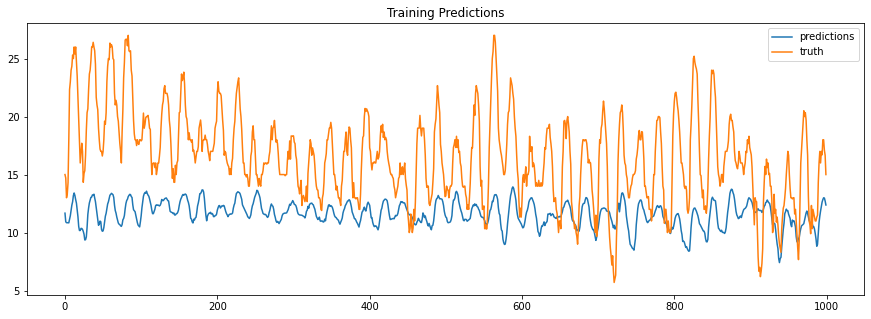

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_preds, label="predictions")
plt.plot(labels, label="truth")
plt.title("Training Predictions")
plt.legend()
plt.show()

Next, we check the test set.

In [ ]:
start_idx = 0
interval_len = 1000

# Extract the true labels for this sequence (not re-scaled!)
labels_test = y_test[start_idx : start_idx + interval_len]

# Extract predictions from our model for this sequence.
input_x_test = X_test_rescaled[start_idx : start_idx + interval_len]
scaled_test_preds = model.predict(np.expand_dims(input_x_test, axis=0))[0]

# Invert our pre-processing scale transforms.
y_test_preds = y_rescaler.inverse_transform(scaled_test_preds)

# Check that the final shapes match
print(y_test_preds.shape, labels_test.shape)

(1000, 1) (1000, 1)


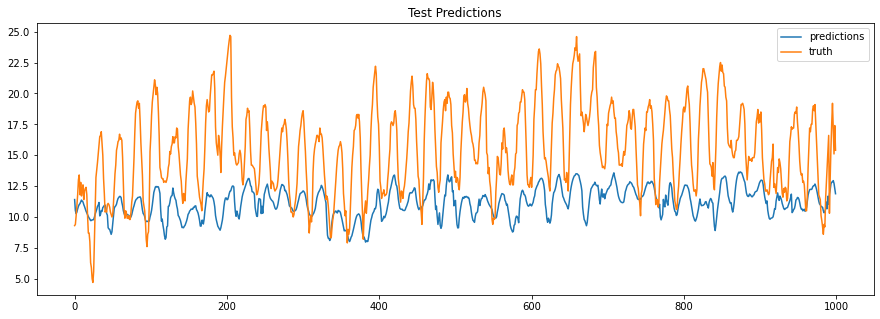

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_test_preds, label="predictions")
plt.plot(labels_test, label="truth")
plt.title("Test Predictions")
plt.legend()
plt.show()

# Homework

**Task 1. (Feed-Forward and Linear Model)** Implement the best possible linear model and feed-forward neural network model you can on the data.

In [ ]:
# Add all relevant code here with relevant accuracy measures, training, and plots
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

num_signals = X_train_rescaled.shape[1]   # 4 in our case
num_y_signals = y_train_rescaled.shape[1] # 1 in our case

model = Sequential()
model.add(Dense(units=512, input_shape=(None, num_signals)))
model.add(Dense(256))
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(num_y_signals, activation='sigmoid'))
opt = RMSprop(lr=1e-3)
model.compile(loss='mean_squared_error', optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, None, 512)         2560      
_________________________________________________________________
dense_2 (Dense)              (None, None, 256)         131328    
_________________________________________________________________
dense_3 (Dense)              (None, None, 128)         32896     
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           129       
Total params: 166,913
Trainable params: 166,913
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train_keras, y_train_keras, epochs=20, steps_per_epoch=200, batch_size=256)

Epoch 1/20
128/200 [==================>...........] - ETA: 31s - loss: 0.0088

KeyboardInterrupt: ignored

In [ ]:
# We will only plot a subset of the data
start_idx = 100000
interval_len = 1000

# Extract the true labels for this sequence (not re-scaled!)
labels = y_train[start_idx : start_idx + interval_len]

# Extract predictions from our model for this sequence.
input_x = X_train_rescaled[start_idx : start_idx + interval_len]
scaled_preds = model.predict(np.expand_dims(input_x, axis=0))[0]

# Invert our pre-processing scale transforms.
y_preds = y_rescaler.inverse_transform(scaled_preds)

# Check that the final shapes match
print(y_preds.shape, labels.shape)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_preds, label="predictions")
plt.plot(labels, label="truth")
plt.title("Training Predictions")
plt.legend()
plt.show()

In [ ]:
result = model.evaluate(x=np.expand_dims(X_test_rescaled, axis=0),
                        y=np.expand_dims(y_test_rescaled, axis=0))

In [ ]:
start_idx = 0
interval_len = 1000

# Extract the true labels for this sequence (not re-scaled!)
labels_test = y_test[start_idx : start_idx + interval_len]

# Extract predictions from our model for this sequence.
input_x_test = X_test_rescaled[start_idx : start_idx + interval_len]
scaled_test_preds = model.predict(np.expand_dims(input_x_test, axis=0))[0]

# Invert our pre-processing scale transforms.
y_test_preds = y_rescaler.inverse_transform(scaled_test_preds)

# Check that the final shapes match
print(y_test_preds.shape, labels_test.shape)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_test_preds, label="predictions")
plt.plot(labels_test, label="truth")
plt.title("Test Predictions")
plt.legend()
plt.show()

**Task 2. (Very simple benchmarks)** Construct the following two benchmark models (a) Always predicting the previous time-step's value and (b) Predicting a moving average of the last K values. Compare those benchmarks to your above linear model, feedforward model, and the starting (bad) RNN model.


In [ ]:
#Predict last time step
preds = df[['Temp']]
preds.head()
(df[['Temp']].subtract(preds)**2).mean()

#Rolling means
k = 20
rolling_means = preds.rolling(k).mean()
(df[['Temp']].subtract(rolling_means)**2).mean()

**Task 3. (Improve the RNN)** Our RNN did not do very well, but with some playing of hyperparameters, you should be able to get much better results! Try tuning the loss functions, number of steps per epoch, activation functions, etc.


In [ ]:
# Add all code for improved model here
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

num_signals = X_train_rescaled.shape[1]   # 4 in our case
num_y_signals = y_train_rescaled.shape[1] # 1 in our case

model = Sequential()
model.add(SimpleRNN(units=256, input_shape=(None, num_signals), return_sequences=True, activation=None))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_y_signals, activation='sigmoid'))
model.compile(loss="mean_squared_error", optimizer="rmsprop")
model.summary()

In [ ]:
model.fit(X_train_keras, y_train_keras, epochs=5, steps_per_epoch=100, batch_size=32)

In [ ]:
# We will only plot a subset of the data
start_idx = 100000
interval_len = 1000

# Extract the true labels for this sequence (not re-scaled!)
labels = y_train[start_idx : start_idx + interval_len]

# Extract predictions from our model for this sequence.
input_x = X_train_rescaled[start_idx : start_idx + interval_len]
scaled_preds = model.predict(np.expand_dims(input_x, axis=0))[0]

# Invert our pre-processing scale transforms.
y_preds = y_rescaler.inverse_transform(scaled_preds)

# Check that the final shapes match
print(y_preds.shape, labels.shape)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_preds, label="predictions")
plt.plot(labels, label="truth")
plt.title("Training Predictions")
plt.legend()
plt.show()

In [ ]:
result = model.evaluate(x=np.expand_dims(X_test_rescaled, axis=0),
                        y=np.expand_dims(y_test_rescaled, axis=0))

In [ ]:
start_idx = 0
interval_len = 1000

# Extract the true labels for this sequence (not re-scaled!)
labels_test = y_test[start_idx : start_idx + interval_len]

# Extract predictions from our model for this sequence.
input_x_test = X_test_rescaled[start_idx : start_idx + interval_len]
scaled_test_preds = model.predict(np.expand_dims(input_x_test, axis=0))[0]

# Invert our pre-processing scale transforms.
y_test_preds = y_rescaler.inverse_transform(scaled_test_preds)

# Check that the final shapes match
print(y_test_preds.shape, labels_test.shape)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_test_preds, label="predictions")
plt.plot(labels_test, label="truth")
plt.title("Test Predictions")
plt.legend()
plt.show()




**Task 4. (Randomization)** Go back to the cell in which we created the data for input to Keras (i.e., the first cell in the "Creating and Training the Model" section). After creating the `X_train_keras`, `y_train_keras`, `X_test_keras`, and `y_test_keras` arrays, shuffle the data randomly along the first axis so that the neural network doesn't see the sequences in contiguous order. Does this change your results?

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

num_signals = X_train_rescaled.shape[1]   # 4 in our case
num_y_signals = y_train_rescaled.shape[1] # 1 in our case

model = Sequential()
model.add(SimpleRNN(units=256, input_shape=(None, num_signals), return_sequences=True, activation=None))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_y_signals, activation='sigmoid'))
model.compile(loss="mean_squared_error", optimizer="rmsprop")
model.summary()

In [ ]:
model.fit(X_train_keras, y_train_keras, epochs=10, steps_per_epoch=100, batch_size=32, shuffle=True)

In [ ]:
# We will only plot a subset of the data
start_idx = 100000
interval_len = 1000

# Extract the true labels for this sequence (not re-scaled!)
labels = y_train[start_idx : start_idx + interval_len]

# Extract predictions from our model for this sequence.
input_x = X_train_rescaled[start_idx : start_idx + interval_len]
scaled_preds = model.predict(np.expand_dims(input_x, axis=0))[0]

# Invert our pre-processing scale transforms.
y_preds = y_rescaler.inverse_transform(scaled_preds)

# Check that the final shapes match
print(y_preds.shape, labels.shape)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_preds, label="predictions")
plt.plot(labels, label="truth")
plt.title("Training Predictions")
plt.legend()
plt.show()

In [ ]:
result = model.evaluate(x=np.expand_dims(X_test_rescaled, axis=0),
                        y=np.expand_dims(y_test_rescaled, axis=0))

In [ ]:
start_idx = 0
interval_len = 1000

# Extract the true labels for this sequence (not re-scaled!)
labels_test = y_test[start_idx : start_idx + interval_len]

# Extract predictions from our model for this sequence.
input_x_test = X_test_rescaled[start_idx : start_idx + interval_len]
scaled_test_preds = model.predict(np.expand_dims(input_x_test, axis=0))[0]

# Invert our pre-processing scale transforms.
y_test_preds = y_rescaler.inverse_transform(scaled_test_preds)

# Check that the final shapes match
print(y_test_preds.shape, labels_test.shape)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_test_preds, label="predictions")
plt.plot(labels_test, label="truth")
plt.title("Test Predictions")
plt.legend()
plt.show()

**Task 5. (Validation Set)** If we're going to change hyperparameters, we should have a validation set to test our changes (in addition to our test set)! Go back and add a validation set. Try tuning the number of units in the RNN, the activation function, and the training parameters (e.g., # of epochs).

In [ ]:
# Include all results + model description (using model.describe) for most updated model here
import math
num_examples = X.shape[0]
train_split = int(num_examples*0.8)
print(train_split)
X_train = X[0:train_split, :]
y_train = y[0:train_split, :]

validation_split = int(num_examples*0.9)
X_validation = X[train_split:validation_split, :]
y_validation = y[train_split:validation_split, :]

X_test = X[-1*validation_split:, :]
y_test = y[-1*validation_split:, :]
print(X_validation.shape)
print(X_test.shape)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Rescale the X and y values. Note that these must be rescaled separately
# because the dimensions are different.
rescaler = MinMaxScaler()
X_train_rescaled = rescaler.fit_transform(X_train)
X_test_rescaled = rescaler.transform(X_test)
X_validation_rescaled = rescaler.transform(X_validation)
y_rescaler = MinMaxScaler()
y_train_rescaled = y_rescaler.fit_transform(y_train)
y_test_rescaled = y_rescaler.transform(y_test)
y_validation_rescaled = y_rescaler.transform(y_validation)

# Check rescaling
print(np.min(X_train_rescaled), np.max(X_train_rescaled))
print(np.min(y_train_rescaled), np.max(y_train_rescaled))

In [ ]:
def batch_for_keras(X_data, y_data, seq_length):
  num_examples = X_data.shape[0] - seq_length
  X_res = np.zeros((num_examples, seq_length, X_data.shape[1]))
  y_res = np.zeros((num_examples, seq_length, y_data.shape[1]))
  for i in range(num_examples):
    X_res[i, :, :] = X_data[i : i + seq_length, :]
    y_res[i, :, :] = y_data[i : i + seq_length, :]
  return (X_res, y_res)

seq_length = 24 * 7 # Each sequence will be one week long
X_train_keras, y_train_keras = batch_for_keras(X_train_rescaled, y_train_rescaled, seq_length)
X_validation_keras, y_validation_keras = batch_for_keras(X_validation_rescaled, y_validation_rescaled, seq_length)
X_test_keras, y_test_keras = batch_for_keras(X_test_rescaled, y_test_rescaled, seq_length)
print(X_train_keras.shape)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

num_signals = X_train_rescaled.shape[1]   # 4 in our case
num_y_signals = y_train_rescaled.shape[1] # 1 in our case

model = Sequential()
model.add(SimpleRNN(units=256, input_shape=(None, num_signals), return_sequences=True, activation=None))
model.add(Dropout(0.5))
model.add(Dense(num_y_signals, activation='sigmoid'))
model.compile(loss="mean_squared_error", optimizer="rmsprop")
model.summary()

In [ ]:
model.fit(X_train_keras, y_train_keras, epochs=10, steps_per_epoch=100, batch_size=32, shuffle=True)

In [ ]:
# We will only plot a subset of the data
start_idx = 100000
interval_len = 1000

# Extract the true labels for this sequence (not re-scaled!)
labels = y_train[start_idx : start_idx + interval_len]

# Extract predictions from our model for this sequence.
input_x = X_train_rescaled[start_idx : start_idx + interval_len]
scaled_preds = model.predict(np.expand_dims(input_x, axis=0))[0]

# Invert our pre-processing scale transforms.
y_preds = y_rescaler.inverse_transform(scaled_preds)

# Check that the final shapes match
print(y_preds.shape, labels.shape)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_preds, label="predictions")
plt.plot(labels, label="truth")
plt.title("Training Predictions")
plt.legend()
plt.show()

In [ ]:
validation_result = model.evaluate(x=np.expand_dims(X_validation_rescaled, axis=0),
                        y=np.expand_dims(y_validation_rescaled, axis=0))

In [ ]:
start_idx = 0
interval_len = 1000

# Extract the true labels for this sequence (not re-scaled!)
labels_validation = y_validation[start_idx : start_idx + interval_len]

# Extract predictions from our model for this sequence.
input_x_validation = X_validation_rescaled[start_idx : start_idx + interval_len]
scaled_validation_preds = model.predict(np.expand_dims(input_x_validation, axis=0))[0]

# Invert our pre-processing scale transforms.
y_validation_preds = y_rescaler.inverse_transform(scaled_validation_preds)

# Check that the final shapes match
print(y_validation_preds.shape, labels_validation.shape)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_validation_preds, label="predictions")
plt.plot(labels, label="truth")
plt.title("Training Predictions")
plt.legend()
plt.show()

In [ ]:
result = model.evaluate(x=np.expand_dims(X_test_rescaled, axis=0),
                        y=np.expand_dims(y_test_rescaled, axis=0))

In [ ]:
start_idx = 0
interval_len = 1000

# Extract the true labels for this sequence (not re-scaled!)
labels_test = y_test[start_idx : start_idx + interval_len]

# Extract predictions from our model for this sequence.
input_x_test = X_test_rescaled[start_idx : start_idx + interval_len]
scaled_test_preds = model.predict(np.expand_dims(input_x_test, axis=0))[0]

# Invert our pre-processing scale transforms.
y_test_preds = y_rescaler.inverse_transform(scaled_test_preds)

# Check that the final shapes match
print(y_test_preds.shape, labels_test.shape)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_test_preds, label="predictions")
plt.plot(labels_test, label="truth")
plt.title("Test Predictions")
plt.legend()
plt.show()

**Task 6. (Other Timescale)** We predicted the temperature 24 hours in the future. Repeat the above lab, but predicting one of the other parameters more than 24 hours in the future. What if you predict less than 24 hours in the future? Plot your results.

In [ ]:
# Include plots + results here
target_hours = 48

# Create targets for RNN (Exercise: why do we multiply by -1?)
labels = df[['Temp']].shift(-1 * target_hours)
labels.head()

X = df.values[0:-1 * target_hours]
y = labels.values[0:-1 * target_hours]
print(X.shape, y.shape)

In [ ]:
model.fit(X_train_keras, y_train_keras, epochs=10, steps_per_epoch=100, batch_size=32, shuffle=True)

In [ ]:
# We will only plot a subset of the data
start_idx = 100000
interval_len = 1000

# Extract the true labels for this sequence (not re-scaled!)
labels = y_train[start_idx : start_idx + interval_len]

# Extract predictions from our model for this sequence.
input_x = X_train_rescaled[start_idx : start_idx + interval_len]
scaled_preds = model.predict(np.expand_dims(input_x, axis=0))[0]

# Invert our pre-processing scale transforms.
y_preds = y_rescaler.inverse_transform(scaled_preds)

# Check that the final shapes match
print(y_preds.shape, labels.shape)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_preds, label="predictions")
plt.plot(labels, label="truth")
plt.title("Training Predictions")
plt.legend()
plt.show()

In [ ]:
result = model.evaluate(x=np.expand_dims(X_validation_rescaled, axis=0),
                        y=np.expand_dims(y_validation_rescaled, axis=0))

In [ ]:
start_idx = 0
interval_len = 1000

# Extract the true labels for this sequence (not re-scaled!)
labels_validation = y_validation[start_idx : start_idx + interval_len]

# Extract predictions from our model for this sequence.
input_x_validation = X_validation_rescaled[start_idx : start_idx + interval_len]
scaled_validation_preds = model.predict(np.expand_dims(input_x_validation, axis=0))[0]

# Invert our pre-processing scale transforms.
y_validation_preds = y_rescaler.inverse_transform(scaled_validation_preds)

# Check that the final shapes match
print(y_validation_preds.shape, labels_validation.shape)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_validation_preds, label="predictions")
plt.plot(labels, label="truth")
plt.title("Training Predictions")
plt.legend()
plt.show()

In [ ]:
result = model.evaluate(x=np.expand_dims(X_test_rescaled, axis=0),
                        y=np.expand_dims(y_test_rescaled, axis=0))

In [ ]:
start_idx = 0
interval_len = 1000

# Extract the true labels for this sequence (not re-scaled!)
labels_test = y_test[start_idx : start_idx + interval_len]

# Extract predictions from our model for this sequence.
input_x_test = X_test_rescaled[start_idx : start_idx + interval_len]
scaled_test_preds = model.predict(np.expand_dims(input_x_test, axis=0))[0]

# Invert our pre-processing scale transforms.
y_test_preds = y_rescaler.inverse_transform(scaled_test_preds)

# Check that the final shapes match
print(y_test_preds.shape, labels_test.shape)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_test_preds, label="predictions")
plt.plot(labels_test, label="truth")
plt.title("Test Predictions")
plt.legend()
plt.show()

**Task 7. [Optional] (More Data)** We threw away a huge amount of data at the beginning when we neglected to include the data from other cities! Include the data from all five cities (for training only) and repeat the above analysis. If you'd like, you can change the target city as well.

In [ ]:
# Include plots to compare results

**Task 8. (LSTM)** Implement a model using an LSTM to try to predict the weather (a) 12 hours in the future (b) 24 hours in the future (c) 48 hours in the future and (d) 60 hours in the future. Compare your model to the SimpleRNN you built earlier for the same four tasks.

In [ ]:
# Include a model.describe for LSTM model,  plots + results comparison here

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

num_signals = X_train_rescaled.shape[1]   # 4 in our case
num_y_signals = y_train_rescaled.shape[1] # 1 in our case

model = Sequential()
model.add(LSTM(units=256, input_shape=(None, num_signals), return_sequences=True, activation=None))
model.add(Dropout(0.5))
model.add(Dense(num_y_signals, activation='sigmoid'))
model.compile(loss="mean_squared_error", optimizer="rmsprop")
model.summary()

In [ ]:
model.fit(X_train_keras, y_train_keras, epochs=10, steps_per_epoch=100, batch_size=32, shuffle=True)

In [ ]:
result = model.evaluate(x=np.expand_dims(X_test_rescaled, axis=0),
                        y=np.expand_dims(y_test_rescaled, axis=0))

In [ ]:
start_idx = 0
interval_len = 1000

# Extract the true labels for this sequence (not re-scaled!)
labels_test = y_test[start_idx : start_idx + interval_len]

# Extract predictions from our model for this sequence.
input_x_test = X_test_rescaled[start_idx : start_idx + interval_len]
scaled_test_preds = model.predict(np.expand_dims(input_x_test, axis=0))[0]

# Invert our pre-processing scale transforms.
y_test_preds = y_rescaler.inverse_transform(scaled_test_preds)

# Check that the final shapes match
print(y_test_preds.shape, labels_test.shape)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_test_preds, label="predictions")
plt.plot(labels_test, label="truth")
plt.title("Test Predictions - 12 hours in the future")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_test_preds, label="predictions")
plt.plot(labels_test, label="truth")
plt.title("Test Predictions - 24 hours in the future")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_test_preds, label="predictions")
plt.plot(labels_test, label="truth")
plt.title("Test Predictions - 48 hours in the future")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_test_preds, label="predictions")
plt.plot(labels_test, label="truth")
plt.title("Test Predictions - 60 hours in the future")
plt.legend()
plt.show()

**Task 9. [Optional] (Different Responder)** Try to predict wind speed instead of temperature 24 hours in the future using an LSTM model.

In [ ]:
# Include a model.describe, plots + results comparison here

GRU on Pressure


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

num_signals = X_train_rescaled.shape[1]   # 4 in our case
num_y_signals = y_train_rescaled.shape[1] # 1 in our case

ACTIVATION = ['relu', 'sigmoid', 'tanh', 'linear']
LOSS = ['mse', 'mae']
OPT = ['rmsprop', 'SGD', 'Adam']

model = Sequential()
model.add(GRU(units=128, input_shape=(None, num_signals), return_sequences=True, activation=None))
model.add(Dropout(0.5))
model.add(Dense(num_y_signals, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop')

In [ ]:
model.fit(X_train_keras, y_train_keras, epochs=10, steps_per_epoch=100, batch_size=32, shuffle=True)

Epoch 1/10
100/100 [==============================] - 35s 350ms/step - loss: 0.0072
Epoch 2/10
100/100 [==============================] - 35s 347ms/step - loss: 0.0045
Epoch 3/10
100/100 [==============================] - 34s 343ms/step - loss: 0.0036
Epoch 4/10
100/100 [==============================] - 34s 344ms/step - loss: 0.0033
Epoch 5/10
100/100 [==============================] - 34s 345ms/step - loss: 0.0030
Epoch 6/10
100/100 [==============================] - 35s 345ms/step - loss: 0.0028
Epoch 7/10
100/100 [==============================] - 35s 354ms/step - loss: 0.0027
Epoch 8/10
100/100 [==============================] - 35s 345ms/step - loss: 0.0025
Epoch 9/10
100/100 [==============================] - 34s 343ms/step - loss: 0.0025
Epoch 10/10
100/100 [==============================] - 34s 345ms/step - loss: 0.0025


In [ ]:
result = model.evaluate(x=np.expand_dims(X_test_rescaled, axis=0),
                        y=np.expand_dims(y_test_rescaled, axis=0))

1/1 [==============================] - 0s 1ms/step - loss: 0.0016


In [ ]:
start_idx = 0
interval_len = 1000

# Extract the true labels for this sequence (not re-scaled!)
labels_test = y_test[start_idx : start_idx + interval_len]

# Extract predictions from our model for this sequence.
input_x_test = X_test_rescaled[start_idx : start_idx + interval_len]
scaled_test_preds = model.predict(np.expand_dims(input_x_test, axis=0))[0]

# Invert our pre-processing scale transforms.
y_test_preds = y_rescaler.inverse_transform(scaled_test_preds)

# Check that the final shapes match
print(y_test_preds.shape, labels_test.shape)

(1000, 1) (1000, 1)


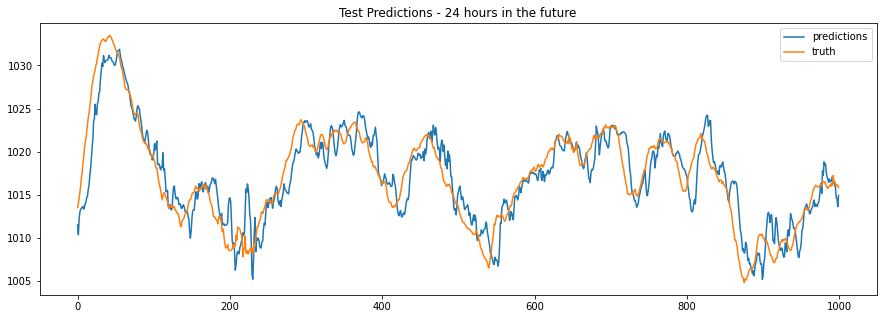

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_test_preds, label="predictions")
plt.plot(labels_test, label="truth")
plt.title("Test Predictions - 12 hours in the future")
plt.legend()
plt.show()